In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math

import linkage_funcs

In [3]:
def compute_input_stiffness(linkage, theta_input, k, rest_angles, delta=1e-4):
    """
    Approximate the stiffness of the system with torsional springs at each joint.

    Parameters:
    linkage: FourBarLinkage instance
    theta_input: input crank angle (radians)
    k: torsional spring stiffness (Nm/rad)
    rest_angles: dict with rest angles at joints, in radians
    delta: small angle change for finite difference

    Returns:
    stiffness: effective torsional stiffness (Nm/rad)
    """
    def total_energy(theta):
        try:
            A, C = linkage.solve_position(theta)
        except ValueError:
            return np.nan  # invalid configuration
        
        theta_C = theta  # input crank angle
        theta_A = np.arctan2(C[1] - A[1], C[0] - A[0])  # angle of AC
        theta_B = np.arctan2(A[1] - linkage.B[1], A[0] - linkage.B[0])  # angle of AB
        theta_D = 0  # fixed, optional spring

        E = 0.5 * k * (theta_A - rest_angles['A'])**2
        E += 0.5 * k * (theta_B - rest_angles['B'])**2
        E += 0.5 * k * (theta_C - rest_angles['C'])**2
        E += 0.5 * k * (theta_D - rest_angles['D'])**2
        return E

    E1 = total_energy(theta_input - delta)
    E2 = total_energy(theta_input)
    E3 = total_energy(theta_input + delta)

    if np.isnan(E1) or np.isnan(E2) or np.isnan(E3):
        return np.nan
    
    return (E1 - 2*E2 + E3) / delta**2

In [4]:
def plot_stiffness_vs_angle(linkage, angles, k, rest_angles):
    """
    Plot effective input stiffness as a function of input crank angle,
    skipping unreachable configurations.

    Parameters:
    linkage: FourBarLinkage instance
    angles: array of input crank angles used in simulation (radians, relative to initial angle)
    k: torsional spring stiffness (Nm/rad)
    rest_angles: dict with rest angles for each joint (radians)
    """
    stiffness_values = []
    absolute_angles = angles + linkage.initial_angle_CD

    for theta in absolute_angles:
        try:
            stiffness = compute_input_stiffness(linkage, theta, k, rest_angles)
        except ValueError:
            stiffness = np.nan  # Mark unreachable configuration
        stiffness_values.append(stiffness)

    stiffness_values = np.array(stiffness_values)
    angle_degrees = np.degrees(angles)  # Relative to initial

    plt.figure(figsize=(10, 5))
    plt.plot(angle_degrees, stiffness_values, 'b-', label='Stiffness')
    plt.xlabel("Input Crank Angle (degrees)")
    plt.ylabel("Effective Input Stiffness (Nm/rad)")
    plt.title("Torsional Stiffness vs Input Crank Angle")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

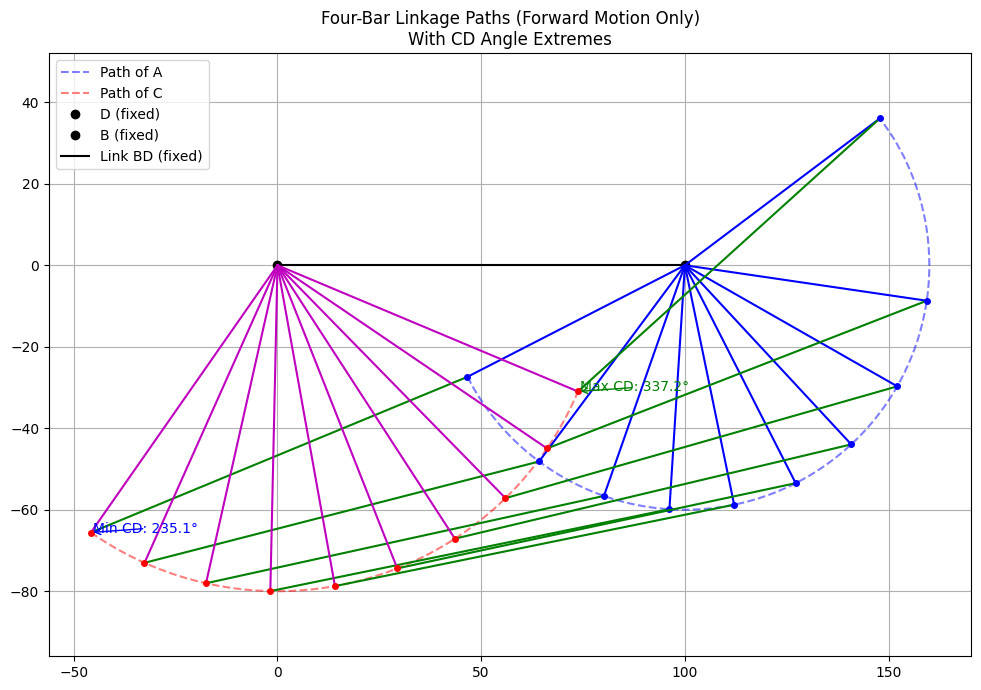

In [5]:
# Parameters
L_AB = 60
L_AC = 100
L_CD = 80
L_BD = 100
initial_angle = 180  # degrees
extension_length = 100

linkage = linkage_funcs.FourBarLinkage(L_AB, L_AC, L_CD, L_BD, initial_angle)
angles, A_pos, C_pos, motion_type = linkage_funcs.run_simulation(linkage)
linkage_funcs.plot_paths(A_pos, C_pos, linkage, angles=angles, num_snapshots=10)

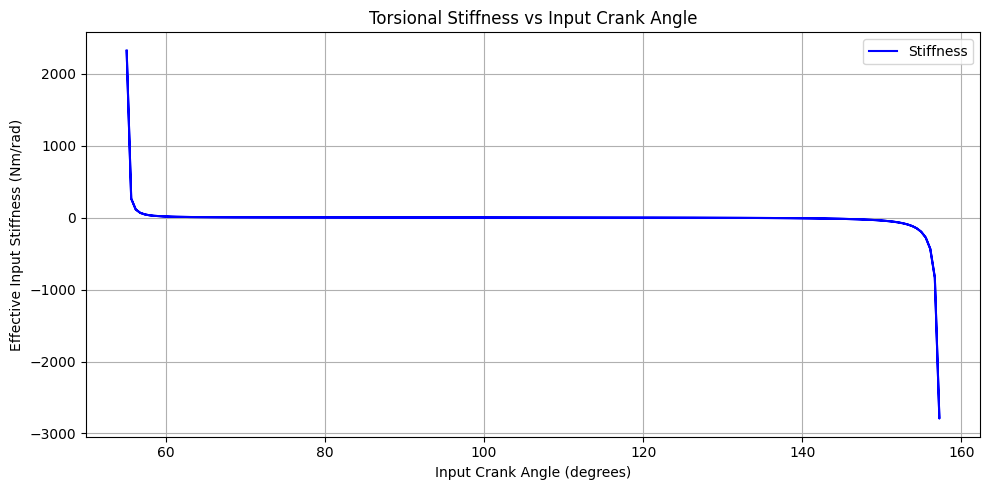

In [18]:
rest_angles = {
    'A': np.pi / 2,  # e.g., AC vertical at rest
    'B': np.pi / 2,  # e.g., AB vertical at rest
    'C': 0.0,        # input crank rest angle
    'D': 0.0         # optional (fixed point)
}

plot_stiffness_vs_angle(linkage, angles, k=1.0, rest_angles=rest_angles)